# Doc2Vec

In [1]:
import gensim # sudo pip3 install gensim
from gensim.models.doc2vec import Doc2Vec
import os
import collections
import numpy as np 
import random
import pickle
import multiprocessing
import pandas as pd

#cores = multiprocessing.cpu_count()
cores = 3

RES = '../res/'
SAMPLE_BOOKS_CLEAN_FOLDER = '../res/books_clean' # 1497 books with Gutenberg header and footer stripped
TOKENIZED_DOCS_FOLDER = '../res/tokenized_docs'

SAMPLE_BOOKS_CLEAN_URL = "http://www.ms.mff.cuni.cz/~bilekja/books_sample_clean.zip"
BOOKS_ZIP_FILENAME = '../res/books_sample_clean.zip'

Download 1497 books from Project Gutenberg. The texts are already preprocessed and headers and footers relating to Project Gutenberg are removed.

In [4]:
!curl "http://www.ms.mff.cuni.cz/~bilekja/books_sample_clean.zip" -o $BOOKS_ZIP_FILENAME

import zipfile
z = zipfile.ZipFile(BOOKS_ZIP_FILENAME)
z.extractall(RES)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187M  100  187M    0     0  2873k      0  0:01:06  0:01:06 --:--:-- 2495k


Get 500 words from the beginning of the book. We skip first 500 words as it may still contain book title, author name, content or other noise.

In [2]:
START_AFTER_WORD = 500
END_BEFORE_WORD = 1000

Tokenize the text and keep 500 words from each text as described above. Pickle the Tagged Documents.

In [57]:
def process_corpus(folder):
    total_books = len(os.listdir(folder))
    i=0
    for filename in os.listdir(folder):
        i+=1
        print("\r{} out of {} books processed".format(i,total_books),end='')
        with open(os.path.join(folder,filename), encoding="utf-8") as f:
            doc_id = filename.split('.')[0]
            book_text = f.read()
            tokens = gensim.utils.simple_preprocess(book_text)
            tokens = tokens[START_AFTER_WORD:END_BEFORE_WORD] # select only part of the book text
            tokenezid_doc = gensim.models.doc2vec.TaggedDocument(tokens, [doc_id])
            pickle.dump(tokenezid_doc,open(os.path.join(TOKENIZED_DOCS_FOLDER, doc_id),'wb'))

process_corpus(SAMPLE_BOOKS_CLEAN_FOLDER)

1497 out of 1497 books processed

Load the Tagged Documents and pickle the whole corpus (might cause problem for big files).

In [2]:
def load_corpus(folder):
    for doc_id in os.listdir(folder):
        yield pickle.load(open(os.path.join(folder, doc_id),'rb'))

corpus = list(load_corpus(TOKENIZED_DOCS_FOLDER))
pickle.dump(corpus,open('../res/corpus_500_words.pkl','wb'))

Populate the vocabulary of the doc2vec model.

In [3]:
#train_corpus = pickle.load(open('../res/corpus_500_words.pkl','rb'))

#model = Doc2Vec(vector_size=50, min_count=2, epochs=55, workers=-1)
#model = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=5, negative=5, hs=0, min_count=2, workers=cores)
#model = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, workers=cores)
model = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
model.build_vocab(corpus)
model.save('../res/model_500_words')

Train the model (might take long time for big corpora).

In [4]:
%time model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)
model.save('../res/model_500_words')

CPU times: user 12.1 s, sys: 116 ms, total: 12.2 s
Wall time: 5.2 s


As the documents are 0 indexed in Doc2Vec, we create a lookup table to keep track of document ids.

In [5]:
lookup_table = dict()
for n, (tokens, key) in enumerate(corpus):
    lookup_table[key[0]] = n
    
book_ids = list(lookup_table.keys())

Representation of document vectors.

In [6]:
docvecs = np.array([model.docvecs[book_id] for book_id in book_ids])

### Fetch metadata catalog

In [7]:
METADATA_CATALOG_URL = 'http://www.ms.mff.cuni.cz/~bilekja/metadata_catalog.pkl.zip'
METADATA_CATALOG_ZIP_PATH = '../res/metadata_catalog.pkl.zip'
METADATA_CATALOG_PATH = '../res/metadata_catalog.pkl'

In [8]:
if not os.path.exists(METADATA_CATALOG_PATH):
    # load the metadata catalog
    !curl $METADATA_CATALOG_URL -o $METADATA_CATALOG_ZIP_PATH
    # unzip it
    z2 = zipfile.ZipFile(METADATA_CATALOG_ZIP_PATH)
    z2.extractall(RES)

# unpickle it - the format is dictionary
metadata_catalog_dict = pickle.load(open(METADATA_CATALOG_PATH,'rb'))
# convert the catalog to pandas DataFrame for more convenient handling
metadata_catalog = pd.DataFrame.from_dict(metadata_catalog_dict, orient='index').set_index('id')
# keep only books we have in our corpus
metadata_catalog = metadata_catalog[metadata_catalog.index.isin(book_ids)]
metadata_catalog.head()

,title,authoryearofdeath,type,author,language,authoryearofbirth,LCC,subjects,formats,downloads
id,,,,,,,,,,
13,The Hunting of the Snark: An Agony in Eight Fits,1898.0,Text,"Carroll, Lewis",[en],1832.0,{PR},"{Nonsense verses, English}",{'application/x-mobipocket-ebook': 'http://www...,304.0
15,Moby Dick,1891.0,Text,"Melville, Herman",[en],1819.0,{PS},"{Whaling -- Fiction, Whaling ships -- Fiction,...",{'application/x-mobipocket-ebook': 'http://www...,856.0
19,The Song of Hiawatha,1882.0,Text,"Longfellow, Henry Wadsworth",[en],1807.0,{PS},"{Indians of North America -- Poetry, Iroquois ...",{'application/x-mobipocket-ebook': 'http://www...,241.0
20,Paradise Lost,1674.0,Text,"Milton, John",[en],1608.0,{PR},{Bible. Genesis -- History of Biblical events ...,{'application/x-mobipocket-ebook': 'http://www...,2252.0
22,Roget's Thesaurus,1869.0,Text,"Roget, Peter Mark",[en],1779.0,{PE},{English language -- Synonyms and antonyms},{'application/x-mobipocket-ebook': 'http://www...,328.0


Display most common authors along with number of books in the corpus.

In [9]:
author_counts = collections.Counter(metadata_catalog.author)
author_counts.most_common(10)

[('Shakespeare, William', 156),
 ('Balzac, Honoré de', 92),
 ('Harte, Bret', 48),
 ('Galsworthy, John', 32),
 (None, 31),
 ('Davis, Richard Harding', 28),
 ('Haggard, H. Rider (Henry Rider)', 26),
 ('London, Jack', 24),
 ('Doyle, Arthur Conan', 23),
 ('James, Henry', 22)]

Select 8 most common authors (excluding the author None).

In [10]:
most_common_authors = [author for author, count in author_counts.most_common(9)
                           if author != None]

Initialize variable authors that contains the author's name if the author is one of the most_common_authors. Put 'Other' otherwise.

In [11]:
authors = metadata_catalog.loc[[int(b) for b in book_ids]].author
authors.where(authors.isin(most_common_authors), 'Other', inplace=True)

# PCA authors

In [31]:
from sklearn.decomposition.pca import PCA
pca = PCA(2)
docvecs_pca = pca.fit_transform(docvecs)

In [32]:
from matplotlib import pyplot as plt
colors = plt.cm.Set1(np.linspace(0, 1, 9))
markers = ['o','v','^','s','P','*','h','x','D']
color_dict = {a : (colors[n], markers[n]) for n,a in enumerate(authors.unique())}

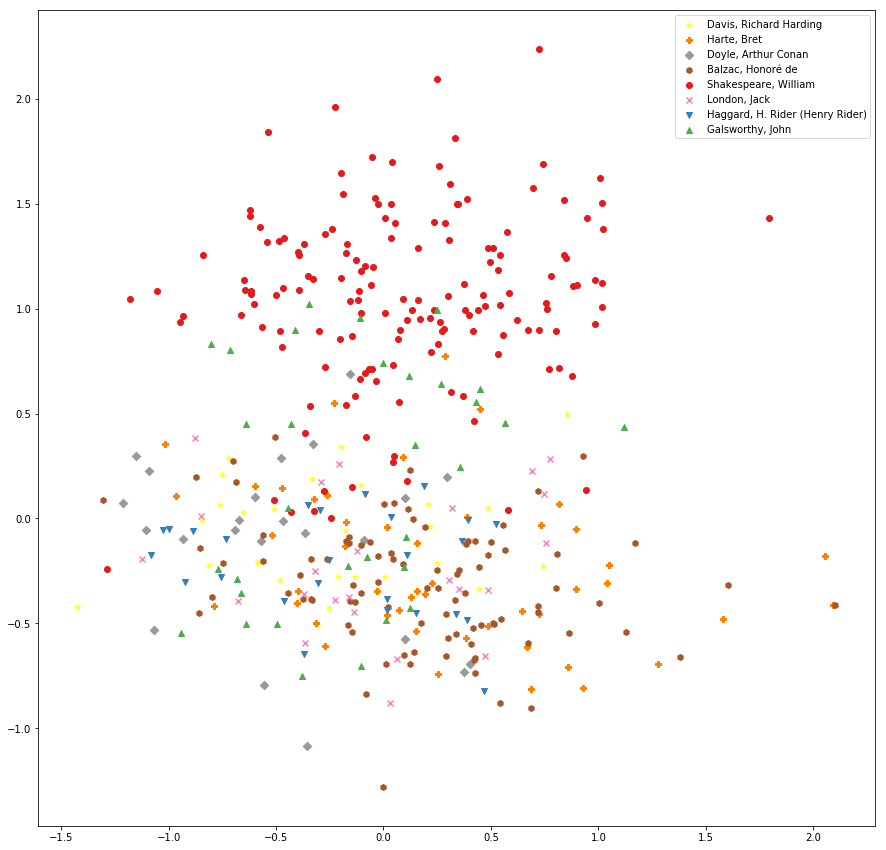

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for author,(color, marker) in color_dict.items():
    x = docvecs_pca[authors == author, 0]
    y = docvecs_pca[authors == author, 1]
    if author == 'Other':
        continue
        alpha = 0.1
    else:
        alpha = 1
    ax.scatter(x, y, label=author, c=color, marker=marker, alpha=alpha)
    
ax.legend()

# TSNE authors

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
docvecs_tsne = tsne.fit_transform(docvecs)

In [35]:
from matplotlib import pyplot as plt
colors = plt.cm.Set1(np.linspace(0, 1, 9))
markers = ['o','v','^','s','P','*','h','x','D']
color_dict = {a : (colors[n], markers[n]) for n,a in enumerate(authors.unique())}

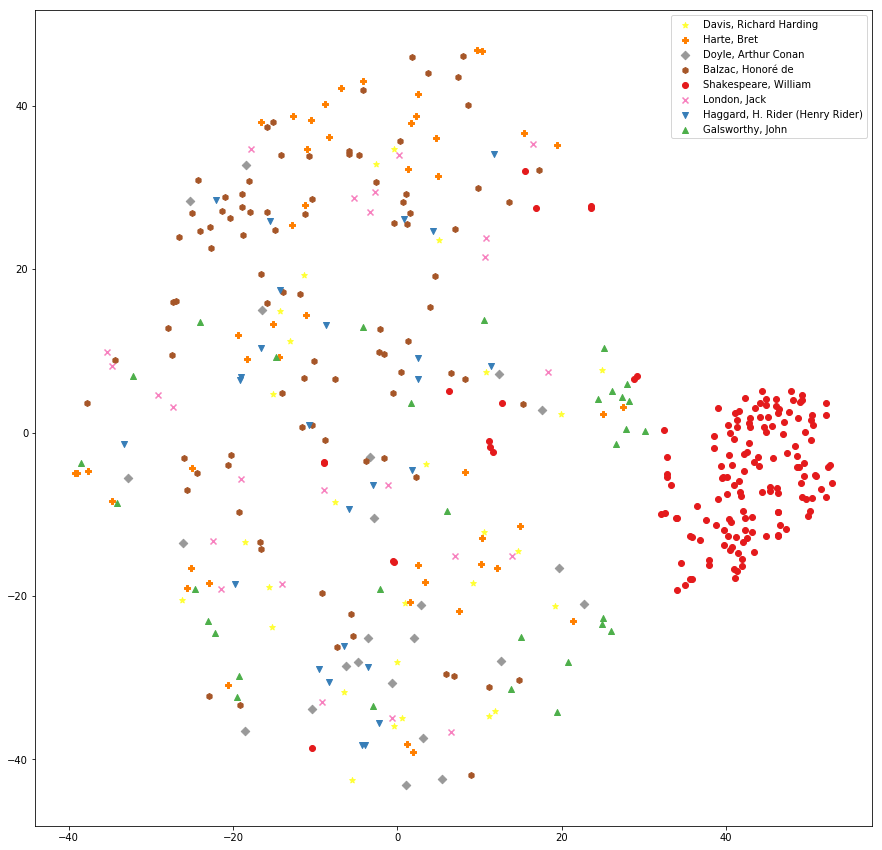

In [36]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for author,(color, marker) in color_dict.items():
    x = docvecs_tsne[authors == author, 0]
    y = docvecs_tsne[authors == author, 1]
    if author == 'Other':
        continue
        alpha = 0.1
    else:
        alpha = 1
    ax.scatter(x, y, label=author, c=color, marker=marker, alpha=alpha)
    
ax.legend()

# TODO:
- PCA, TSNE for genres
- most similar book for Sherlock and Pride and Prejudice
- not hardcoded markers/colors for specific length